### Import PySHRED

In [1]:
from example_helper import *

%load_ext autoreload
%autoreload 2
import importlib
import pyshred
importlib.reload(pyshred)  # Reload the entire package
from pyshred import SHREDDataManager, SHRED, evaluate

### Initialize SHREDDataManager and add datasets

In [124]:
import os

coordinates = [(100,200),(90,190),(60,240)]

# Initialize SHREDDataManager
manager = SHREDDataManager(
    lags = 20,
    train_size = 0.7,
    val_size = 0.15,
    test_size = 0.15,
    compression=False,
    method="all"
)

file_path = "datasets/sea_surface_temperature/SST_data.npy"
manager.add(
    data=file_path,
    # random_sensors=3,
    stationary_sensors = [(46, 227),(120, 60),(134, 303)],
    # stationary_sensors=coordinates,
    id = "SST"
)

In [125]:
manager.sensor_summary

,field id,sensor id,sensor type,location/trajectory
0,SST,SST-0,stationary (user selected),"(46, 227)"
1,SST,SST-1,stationary (user selected),"(120, 60)"
2,SST,SST-2,stationary (user selected),"(134, 303)"


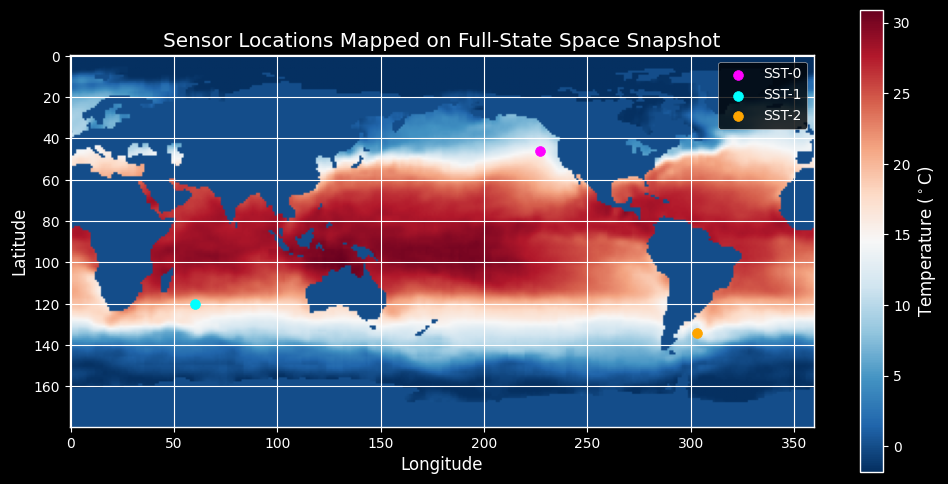

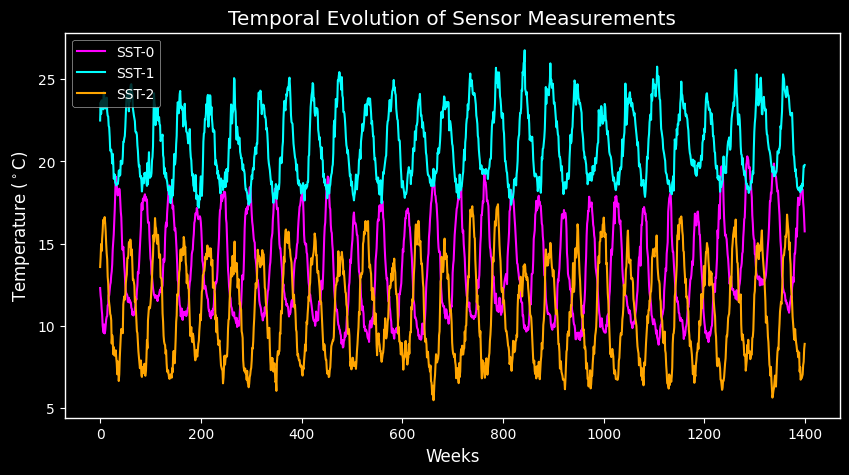

In [134]:
import numpy as np
import matplotlib.pyplot as plt

t = 100

dataset = np.load('datasets/sea_surface_temperature/SST_data.npy')
data = dataset[t,:]
sensor_ids = manager.sensor_summary["sensor id"].tolist()

# Create the plot
plt.figure(figsize=(12, 6))
im = plt.imshow(data, cmap='RdBu_r', origin="upper")  # (0,0) is top-left

# Add sensor locations as dots
plt.scatter(x=manager.sensor_summary.loc[manager.sensor_summary["sensor id"] == "SST-0", "location/trajectory"].values[0][1],
            y=manager.sensor_summary.loc[manager.sensor_summary["sensor id"] == "SST-0", "location/trajectory"].values[0][0],
            color='magenta', s=50, label=sensor_ids[0])
plt.scatter(x=manager.sensor_summary.loc[manager.sensor_summary["sensor id"] == "SST-1", "location/trajectory"].values[0][1],
            y=manager.sensor_summary.loc[manager.sensor_summary["sensor id"] == "SST-1", "location/trajectory"].values[0][0],
            color='cyan', s=50, label=sensor_ids[1])
plt.scatter(x=manager.sensor_summary.loc[manager.sensor_summary["sensor id"] == "SST-2", "location/trajectory"].values[0][1],
            y=manager.sensor_summary.loc[manager.sensor_summary["sensor id"] == "SST-2", "location/trajectory"].values[0][0],
            color='orange', s=50, label=sensor_ids[2])


# Customize plot appearance
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Sensor Locations Mapped on Full-State Space Snapshot")
plt.legend()
plt.colorbar(im, label=r"Temperature ($^\circ$C)")

# Show the plot
plt.show()


sensor_measurements_df = manager.sensor_measurements

# Plotting the time series
plt.figure(figsize=(10, 5))
plt.style.use('dark_background')



plt.plot(sensor_measurements_df["time"], sensor_measurements_df["SST-0"], label="SST-0", color = 'magenta')
plt.plot(sensor_measurements_df["time"], sensor_measurements_df["SST-1"], label="SST-1", color = 'cyan')
plt.plot(sensor_measurements_df["time"], sensor_measurements_df["SST-2"], label="SST-2", color = 'Orange')

plt.xlabel("Weeks")
plt.ylabel(r"Temperature ($^\circ$C)")
plt.title("Temporal Evolution of Sensor Measurements")
plt.legend()
plt.grid()

# Display the plot
plt.show()



In [4]:
manager.sensor_measurements

,time,SST-0,SST-1,SST-2
0,0,12.29,-1.80,13.57
1,1,11.83,-1.80,14.16
2,2,11.56,-1.80,14.97
3,3,11.02,-1.80,14.54
4,4,10.69,-1.80,15.31
...,...,...,...,...
1395,1395,18.28,1.85,7.03
1396,1396,17.50,1.22,7.60
1397,1397,17.15,0.83,7.79
1398,1398,16.49,0.64,8.58


### Get train/val/test datasets

In [21]:
train_dataset, val_dataset, test_dataset = manager.preprocess()

### Initialize SHRED and fit

In [11]:
# initialize SHRED
shred = SHRED(sequence='LSTM', decoder='SDN')
# fit SHRED
val_errors = shred.fit(train_dataset, val_dataset, num_epochs=1000)


Fitting Reconstructor...


Epoch 1/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 2/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 3/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 4/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 5/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 6/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 7/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 8/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 9/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 10/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 11/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 12/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 13/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 14/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 15/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 16/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 17/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 18/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 19/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 20/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 21/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 22/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 23/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 24/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 25/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 26/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 27/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 28/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 29/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 30/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 31/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 32/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 33/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 34/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 35/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 36/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 37/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 38/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 39/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 40/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 41/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 42/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 43/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 44/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 45/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 46/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 47/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 48/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 49/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 50/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 51/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 52/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 53/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 54/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 55/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 56/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 57/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 58/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 59/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 60/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 61/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 62/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 63/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 64/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 65/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 66/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 67/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 68/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 69/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 70/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 71/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 72/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 73/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 74/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 75/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 76/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 77/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 78/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 79/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 80/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 81/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 82/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 83/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 84/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 85/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 86/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 87/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 88/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 89/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 90/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 91/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 92/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 93/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 94/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 95/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 96/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 97/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 98/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 99/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 100/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 101/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 102/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 103/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 104/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 105/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 106/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 107/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 108/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 109/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 110/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 111/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 112/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 113/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 114/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 115/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 116/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 117/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 118/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 119/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 120/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 121/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 122/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 123/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 124/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 125/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 126/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 127/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 128/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 129/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 130/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 131/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 132/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 133/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 134/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 135/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 136/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 137/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 138/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 139/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 140/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 141/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 142/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 143/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 144/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 145/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 146/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 147/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 148/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 149/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 150/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 151/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 152/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 153/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 154/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 155/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 156/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 157/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 158/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 159/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 160/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 161/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 162/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 163/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 164/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 165/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 166/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 167/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 168/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 169/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 170/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 171/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 172/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 173/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 174/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 175/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 176/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 177/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 178/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 179/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 180/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 181/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 182/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 183/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 184/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 185/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 186/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 187/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 188/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 189/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 190/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 191/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 192/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 193/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 194/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 195/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 196/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 197/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 198/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 199/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 200/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 201/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 202/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 203/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 204/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 205/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 206/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 207/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 208/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 209/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 210/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 211/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 212/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 213/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 214/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 215/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 216/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 217/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 218/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 219/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 220/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 221/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 222/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 223/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 224/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 225/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 226/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 227/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 228/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 229/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 230/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 231/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 232/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 233/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 234/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 235/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 236/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 237/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 238/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 239/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 240/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 241/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 242/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 243/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 244/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 245/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 246/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 247/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 248/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 249/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 250/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 251/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 252/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 253/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 254/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 255/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 256/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 257/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 258/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 259/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 260/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 261/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 262/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 263/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 264/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 265/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 266/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 267/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 268/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 269/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 270/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 271/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 272/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 273/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 274/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 275/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 276/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 277/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 278/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 279/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 280/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 281/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 282/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 283/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 284/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 285/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 286/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 287/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 288/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 289/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 290/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 291/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 292/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 293/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 294/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 295/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 296/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 297/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 298/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 299/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 300/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 301/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 302/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 303/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 304/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 305/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 306/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 307/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 308/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 309/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 310/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 311/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 312/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 313/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 314/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 315/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 316/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 317/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 318/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 319/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 320/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 321/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 322/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 323/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 324/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 325/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 326/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 327/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 328/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 329/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 330/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 331/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 332/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 333/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 334/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 335/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 336/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 337/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 338/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 339/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 340/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 341/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 342/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 343/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 344/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 345/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 346/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 347/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 348/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 349/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 350/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 351/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 352/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 353/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 354/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 355/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 356/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 357/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 358/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 359/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 360/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 361/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 362/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 363/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 364/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 365/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 366/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 367/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 368/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 369/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 370/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 371/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 372/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 373/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 374/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 375/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 376/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 377/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 378/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 379/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 380/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 381/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 382/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 383/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 384/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 385/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 386/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 387/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 388/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 389/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 390/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 391/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 392/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 393/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 394/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 395/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 396/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 397/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 398/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 399/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 400/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 401/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 402/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 403/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 404/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 405/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 406/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 407/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 408/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 409/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 410/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 411/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 412/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 413/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 414/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 415/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 416/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 417/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 418/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 419/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 420/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 421/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 422/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 423/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 424/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 425/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 426/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 427/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 428/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 429/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 430/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 431/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 432/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 433/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 434/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 435/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 436/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 437/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 438/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 439/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 440/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 441/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 442/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 443/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 444/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 445/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 446/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 447/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 448/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 449/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 450/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 451/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 452/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 453/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 454/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 455/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 456/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 457/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 458/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 459/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 460/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 461/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 462/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 463/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 464/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 465/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 466/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 467/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 468/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 469/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 470/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 471/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 472/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 473/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 474/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 475/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 476/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 477/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 478/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 479/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 480/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 481/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 482/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 483/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 484/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 485/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 486/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 487/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 488/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 489/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 490/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 491/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 492/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 493/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 494/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 495/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 496/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 497/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 498/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 499/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 500/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 501/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 502/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 503/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 504/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 505/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 506/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 507/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 508/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 509/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 510/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 511/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 512/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 513/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 514/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 515/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 516/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 517/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 518/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 519/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 520/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 521/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 522/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 523/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 524/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 525/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 526/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 527/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 528/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 529/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 530/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 531/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 532/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 533/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 534/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 535/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 536/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 537/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 538/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 539/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 540/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 541/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 542/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 543/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 544/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 545/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 546/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 547/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 548/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 549/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 550/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 551/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 552/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 553/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 554/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 555/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 556/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 557/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 558/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 559/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 560/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 561/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 562/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 563/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 564/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 565/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 566/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 567/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 568/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 569/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 570/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 571/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 572/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 573/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 574/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 575/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 576/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 577/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 578/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 579/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 580/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 581/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 582/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 583/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 584/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 585/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 586/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 587/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 588/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 589/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 590/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 591/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 592/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 593/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 594/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 595/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 596/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 597/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 598/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 599/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 600/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 601/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 602/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 603/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 604/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 605/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 606/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 607/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 608/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 609/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 610/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 611/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 612/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 613/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 614/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 615/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 616/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 617/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 618/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 619/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 620/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 621/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 622/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 623/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 624/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 625/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 626/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 627/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 628/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 629/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 630/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 631/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 632/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 633/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 634/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 635/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 636/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 637/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 638/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 639/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 640/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 641/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 642/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 643/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 644/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 645/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 646/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 647/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 648/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 649/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 650/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 651/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 652/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 653/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 654/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 655/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 656/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 657/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 658/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 659/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 660/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 661/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 662/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 663/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 664/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 665/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 666/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 667/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 668/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 669/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 670/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 671/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 672/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 673/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 674/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 675/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 676/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 677/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 678/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 679/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 680/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 681/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 682/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 683/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 684/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 685/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 686/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 687/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 688/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 689/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 690/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 691/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 692/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 693/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 694/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 695/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 696/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 697/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 698/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 699/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 700/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 701/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 702/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 703/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 704/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 705/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 706/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 707/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 708/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 709/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 710/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 711/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 712/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 713/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 714/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 715/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 716/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 717/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 718/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 719/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 720/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 721/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 722/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 723/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 724/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 725/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 726/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 727/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 728/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 729/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 730/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 731/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 732/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 733/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 734/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 735/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 736/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 737/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 738/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 739/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 740/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 741/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 742/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 743/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 744/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 745/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 746/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 747/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 748/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 749/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 750/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 751/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 752/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 753/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 754/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 755/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 756/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 757/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 758/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 759/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 760/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 761/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 762/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 763/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 764/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 765/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 766/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 767/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 768/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 769/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 770/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 771/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 772/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 773/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 774/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 775/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 776/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 777/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 778/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 779/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 780/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 781/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 782/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 783/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 784/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 785/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 786/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 787/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 788/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 789/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 790/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 791/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 792/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 793/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 794/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 795/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 796/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 797/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 798/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 799/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 800/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 801/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 802/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 803/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 804/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 805/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 806/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 807/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 808/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 809/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 810/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 811/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 812/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 813/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 814/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 815/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 816/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 817/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 818/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 819/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 820/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 821/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 822/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 823/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 824/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 825/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 826/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 827/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 828/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 829/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 830/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 831/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 832/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 833/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 834/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 835/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 836/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 837/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 838/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 839/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 840/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 841/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 842/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 843/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 844/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 845/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 846/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 847/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 848/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 849/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 850/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 851/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 852/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 853/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 854/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 855/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 856/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 857/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 858/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 859/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 860/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 861/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 862/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 863/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 864/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 865/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 866/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 867/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 868/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 869/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 870/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 871/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 872/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 873/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 874/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 875/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 876/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 877/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 878/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 879/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 880/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 881/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 882/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 883/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 884/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 885/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 886/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 887/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 888/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 889/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 890/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 891/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 892/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 893/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 894/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 895/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 896/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 897/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 898/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 899/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 900/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 901/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 902/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 903/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 904/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 905/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 906/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 907/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 908/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 909/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 910/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 911/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 912/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 913/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 914/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 915/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 916/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 917/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 918/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 919/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 920/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 921/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 922/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 923/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 924/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 925/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 926/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 927/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 928/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 929/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 930/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 931/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 932/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 933/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 934/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 935/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 936/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 937/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 938/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 939/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 940/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 941/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 942/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 943/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 944/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 945/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 946/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 947/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 948/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 949/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 950/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 951/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 952/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 953/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Early stopping triggered: patience threshold reached.

Fitting Predictor...


Epoch 1/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 2/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 3/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 4/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 5/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 6/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 7/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 8/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 9/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 10/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 11/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 12/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 13/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 14/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 15/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 16/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 17/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 18/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 19/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 20/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 21/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 22/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 23/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 24/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 25/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 26/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 27/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 28/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 29/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 30/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 31/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 32/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 33/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 34/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 35/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 36/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 37/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 38/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 39/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 40/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 41/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 42/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 43/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 44/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 45/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 46/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 47/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 48/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 49/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 50/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 51/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 52/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 53/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 54/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 55/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 56/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 57/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 58/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 59/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 60/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 61/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 62/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 63/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 64/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 65/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 66/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 67/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 68/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 69/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 70/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 71/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 72/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 73/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 74/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 75/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 76/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 77/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 78/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 79/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 80/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 81/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 82/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 83/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 84/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 85/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 86/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 87/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 88/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 89/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 90/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 91/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 92/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 93/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 94/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 95/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 96/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 97/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 98/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 99/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 100/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 101/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 102/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 103/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 104/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 105/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 106/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 107/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 108/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 109/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 110/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 111/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 112/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 113/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 114/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 115/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 116/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 117/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 118/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 119/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 120/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 121/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 122/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 123/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 124/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 125/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 126/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 127/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 128/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 129/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 130/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 131/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 132/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 133/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 134/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 135/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 136/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 137/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 138/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 139/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 140/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 141/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 142/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 143/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 144/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 145/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 146/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 147/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 148/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 149/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 150/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 151/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 152/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 153/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 154/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 155/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 156/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 157/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 158/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 159/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 160/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 161/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 162/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 163/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 164/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 165/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 166/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 167/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 168/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 169/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 170/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 171/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 172/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 173/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 174/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 175/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 176/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 177/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 178/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 179/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Early stopping triggered: patience threshold reached.

Fitting Sensor Forecaster...


Epoch 1/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 2/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 3/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 4/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 5/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 6/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 7/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 8/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 9/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 10/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 11/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 12/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 13/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 14/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 15/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 16/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 17/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 18/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 19/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 20/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 21/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 22/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 23/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 24/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 25/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 26/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 27/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 28/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 29/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 30/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 31/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 32/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 33/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 34/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 35/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 36/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 37/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 38/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 39/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 40/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 41/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 42/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 43/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 44/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 45/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 46/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 47/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 48/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 49/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 50/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 51/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 52/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 68/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 69/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 70/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 71/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 72/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 73/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 74/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 75/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 76/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 77/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 78/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 79/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 80/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 81/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 82/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 83/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 84/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 85/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 86/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 87/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 88/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 89/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 90/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 91/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 92/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 93/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 94/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 95/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 96/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 97/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 98/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 99/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 100/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 101/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 102/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 103/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 104/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 105/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 106/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 107/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 108/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 109/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 110/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 111/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 112/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 113/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 114/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 115/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 116/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 117/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 118/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 119/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 120/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 121/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 122/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 138/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 139/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 140/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 141/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 142/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 143/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 144/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 145/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 146/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 147/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 148/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 149/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 150/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 151/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 152/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 153/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 154/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 155/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 156/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 157/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 158/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 159/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 160/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 161/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 162/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 163/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 164/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 165/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 166/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 167/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 168/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 169/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 170/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 171/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 172/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 173/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 174/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 175/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 176/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 177/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 178/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 179/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 180/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 181/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 182/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 183/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 184/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 185/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 186/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 187/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 188/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 189/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 190/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 191/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Epoch 192/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 207/1000:   0%|          | 0/16 [00:00<?, ?batch/s]

Early stopping triggered: patience threshold reached.


### Evaluate SHRED on test dataset

In [12]:
evaluate(model = shred, test_dataset=test_dataset, data_manager=manager)

{0}   {3}
{0}   {3}


,SST
reconstruction,0.021534
prediction,0.051900
forecast,0.048428
sensor_forecast,0.088675


### SHRED Reconstruct

In [13]:
# SHRED Reconstruct
reconstruction = shred.reconstruct(test_dataset.reconstructor_dataset.X)
# Post-processing
dataset_dict_recon = manager.postprocess(reconstruction, method = 'reconstructor')
true_dataset_dict_recon = manager.postprocess(test_dataset.predictor_dataset.Y.cpu().numpy(),  uncompress = True, method = 'reconstructor')

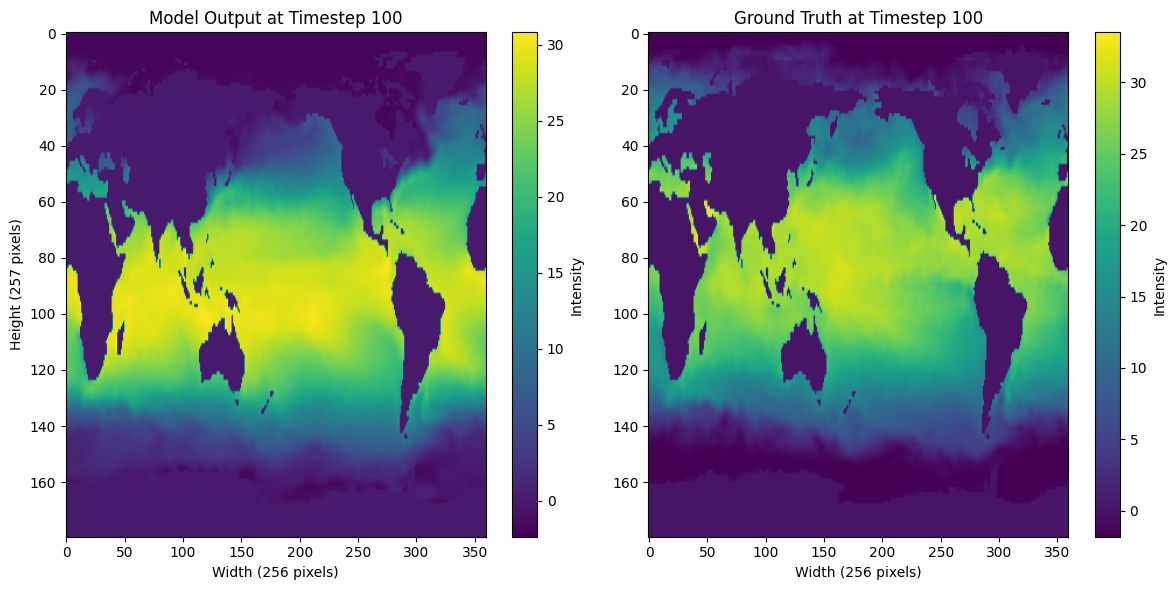

In [16]:
# plot at timestep = 100
t = 100
for key in dataset_dict_recon.keys():
    plot_frame_comparison(dataset_dict_recon[key], true_dataset_dict_recon[key], timestep=t)

### SHRED Predict

In [17]:
# SHRED Predict
prediction = shred.predict(test_dataset.predictor_dataset.X)
dataset_dict_prediction = manager.postprocess(prediction, method = 'predictor')
true_dataset_dict_prediction = manager.postprocess(test_dataset.predictor_dataset.Y.cpu().numpy(), method = 'predictor')

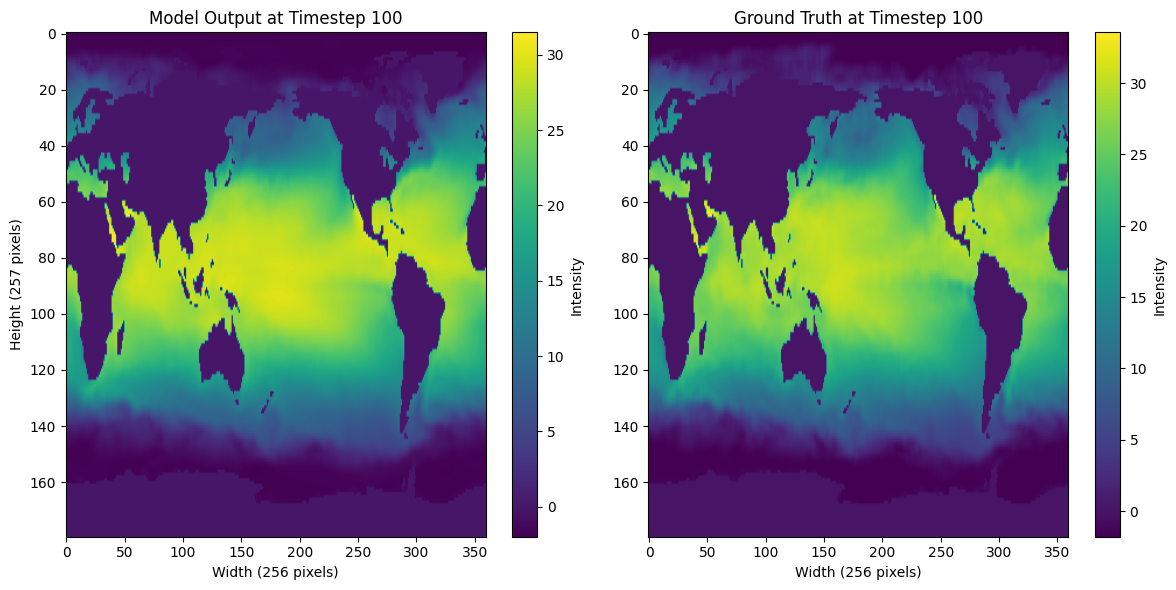

In [18]:
# plot at timestep = 100
t = 100
for key in dataset_dict_prediction.keys():
    plot_frame_comparison(dataset_dict_prediction[key], true_dataset_dict_prediction[key], timestep=t)

### SHRED Forecast

In [21]:
### Forecast Sensors
sensor_measurements_for_prediction = manager.generate_X(start = 1400, end = 1500, method = 'predictor', forecaster = shred.sensor_forecaster)
# SHRED Predict
forecast_out = shred.predict(sensor_measurements_for_prediction)
forecast_post_process = manager.postprocess(forecast_out, uncompress = True, method = 'predictor')

{0}   {3}


In [22]:
forecast_post_process['SST'].shape

(101, 180, 360)